<a href="https://colab.research.google.com/github/BertaZamora/conceptos-claros/blob/master/ENTREGABLE_7_PROYECTO_SATELITE_Prediccion_series_temporales_ejemplo3_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # crear graficos
plt.rcParams["figure.figsize"] = (10,5) # cambiar el tamano de las figuras
import seaborn as sns # graficos con dataframes

import numpy as np # manipulacion de vectores
import pandas as pd # manipulacion de dataframes igual R

import missingno as msno # manipular y visualizar los valores perdidos Nans

from sklearn.feature_selection import mutual_info_classif # calculo de la mutual information o MI

from sklearn.feature_selection import f_classif # calculo de test estadisticos ANOVA
from sklearn.feature_selection import chi2 # calculo del test de chi cuadrado
from sklearn.linear_model import LogisticRegression # calculo de una regresion logistica con sklearn
import statsmodels.api as sm # calculo de regresion logistico mas estadistico tipo R con statsmodels
from sklearn.feature_selection import RFE # algoritmo de quitar variables que no son importantes

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
#from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Lectura de datos, preparación de datos

La columna fecha se ha almacenado como string. Para convertirla en datetime, se emplea la función pd.to_datetime(). Una vez en formato datetime, y para hacer uso de las funcionalidades de pandas, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS').

In [ ]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'master/data/visitas_por_dia_web_cienciadedatos.csv')
datos = pd.read_csv(url, sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    421 non-null    object
 1   users   421 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.7+ KB


In [ ]:
datos.head()

,date,users
0,1/7/20,2324
1,2/7/20,2201
2,3/7/20,2146
3,4/7/20,1666
4,5/7/20,1433


In [ ]:
# Preparacion del dato / Conversión del formato fecha
# ==============================================================================
datos['date'] = pd.to_datetime(datos['date'], format='%d/%m/%y')
datos = datos.set_index('date')
datos = datos.asfreq('1D')
datos = datos.sort_index()

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [ ]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

# Separación de datos training, de validación y de test para puesta en marcha

In [ ]:
# Separación datos train-test
# ==============================================================================
fin_train = '2021-03-30 23:59:00'
fin_validacion = '2021-06-30 23:59:00'

datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train      : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00
Fechas validación : 2021-03-31 00:00:00 --- 2021-06-30 00:00:00
Fechas test       : 2021-07-01 00:00:00 --- 2021-08-25 00:00:00


# Visualización de datos

In [ ]:
# Gráfico serie temporal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(12, 4))
# datos_train.users.plot(ax=ax, label='train', linewidth=1)
# datos_val.users.plot(ax=ax, label='val', linewidth=1)
# datos_test.users.plot(ax=ax, label='test', linewidth=1)
# ax.set_title('Visitas diarias a cienciadedatos.net')
# ax.legend();

plot_train = datos_train.users.hvplot.line(label='train')
plot_val = datos_val.users.hvplot.line(label='val')
plot_test = datos_test.users.hvplot.line(label='test')

layout = plot_train * plot_val * plot_test
layout = layout.opts(title='Visitas diarias a cienciadedatos.net', ylabel='users')
layout

AttributeError: 'Series' object has no attribute 'hvplot'

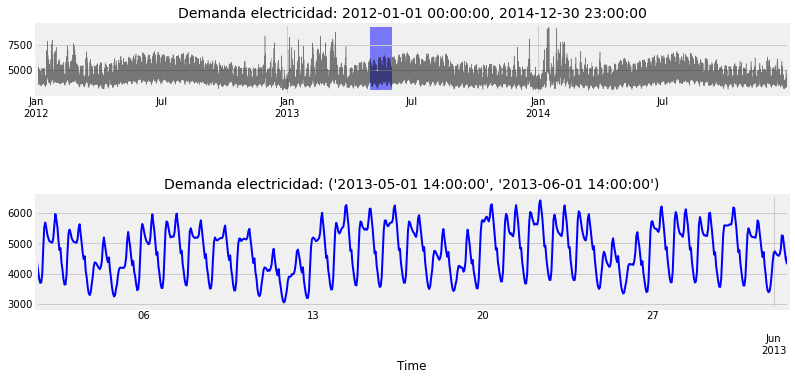

In [ ]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)


<ipython-input-20-33a394d763a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['mes'] = datos.index.month


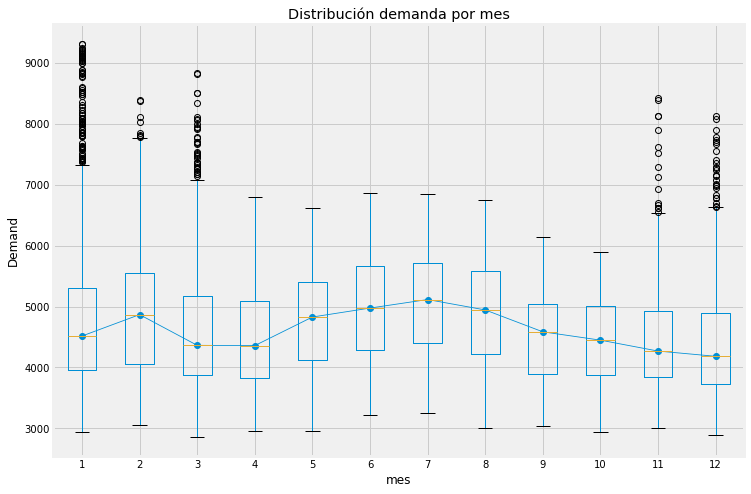

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

<ipython-input-22-6b04b74c3d4f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['dia_semana'] = datos.index.day_of_week + 1


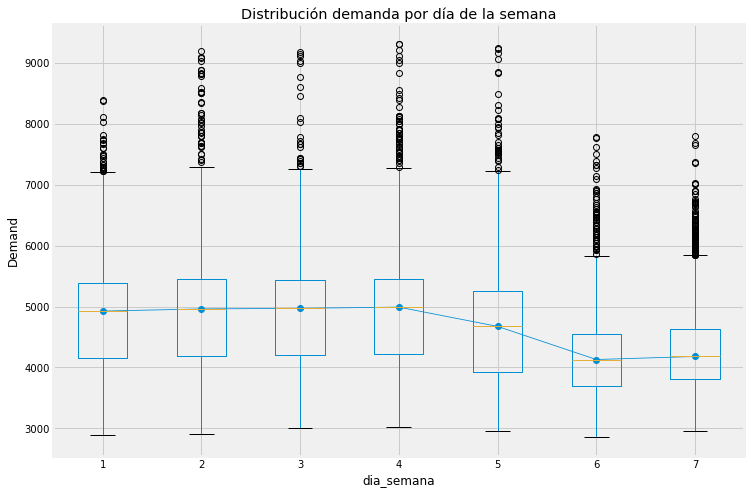

In [ ]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

<ipython-input-23-ed84882f8ff1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['hora_dia'] = datos.index.hour + 1


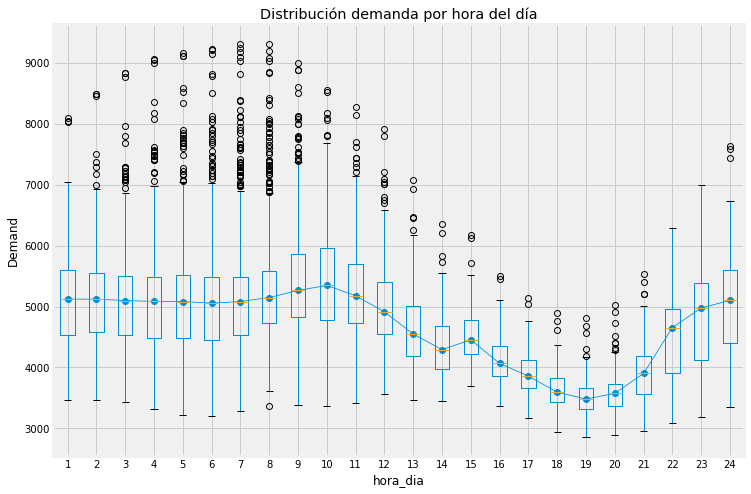

In [ ]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

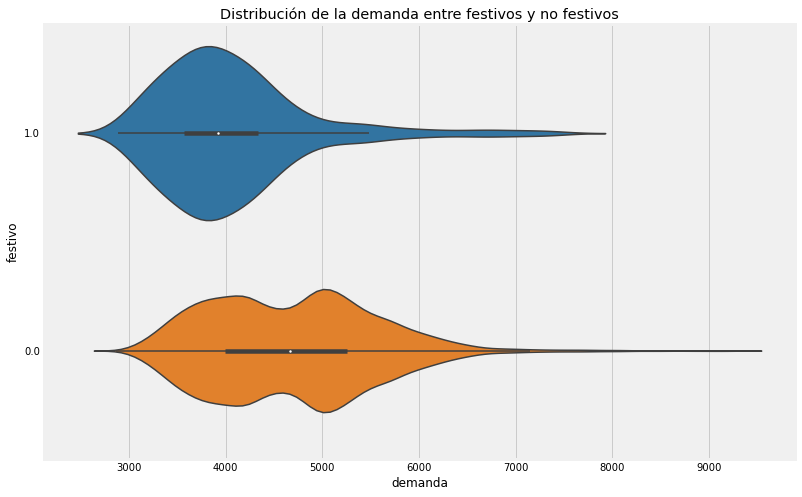

In [ ]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

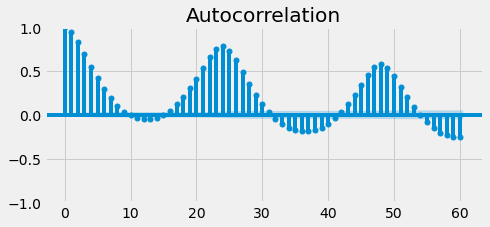

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show()

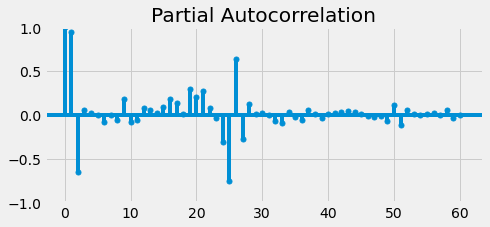

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show()

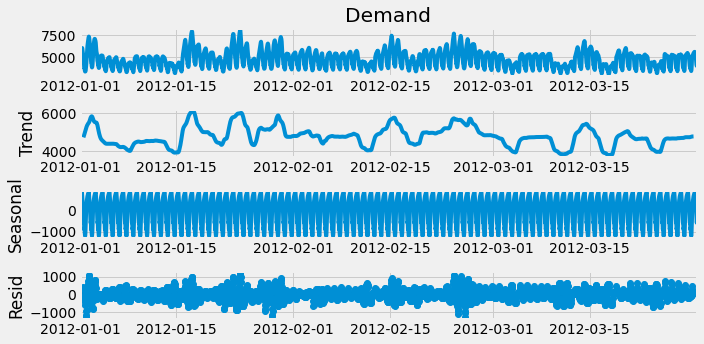

In [ ]:
# Descomposición de la serie temporal:
plt.rcParams["figure.figsize"] = (10,5) # cambiar el tamano de las figuras

from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(datos['Demand'][datos.index<'2012-3-30 15:00:00'], model='additive', period=24)
result.plot()
pyplot.show()

# Modelo y forecasting

Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de regresión lineal con penalización Ridge y una ventana temporal de 24 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de las 24 horas anteriores.

## Training

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-02 12:21:57 
Last fit date: 2022-03-02 12:21:57 
Skforecast version: 0.4.2 

In [ ]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00
Data partition in fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00
Data partition in fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00
Data partition in fold: 5


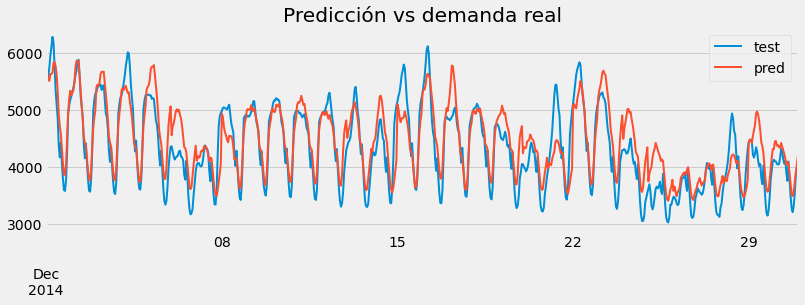

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: [289.5191503]


## Tuning optimización hiper parámeetros

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # Este valor será remplazado en el grid search
              )

# Hiperparámetros del regresor
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:44<00:00, 14.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'ridge__alpha': 215.44346900318823}
  Backtesting metric: 257.8431725056719



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,ridge__alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 215.44346900318823},257.843173,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 27.825594022071257},290.555205,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 3.593813663804626},306.631981,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.46415888336127775},309.393349,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.05994842503189409},309.776084,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.007742636826811269},309.825962,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.001},309.832410,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},325.041129,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},325.043579,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},325.062536,0.059948


Los mejores resultados se obtienen si se utilizan los lags [1, 2, 3, 23, 24, 25, 47, 48, 49] y una configuración de Ridge {'alpha': 215.44}. Al indicar return_best = True en la función grid_search_forecaster(), al final del proceso, se reentrena automáticamente el objeto forecaster con la mejor configuración encontrada y el set de datos completo.

In [ ]:
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=215.44346900318823))]) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Window size: 49 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 215.44346900318823, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-02 12:23:45 
Last fit date: 2022-03-02 12:24:30 
Skforecast version: 0.4.2 

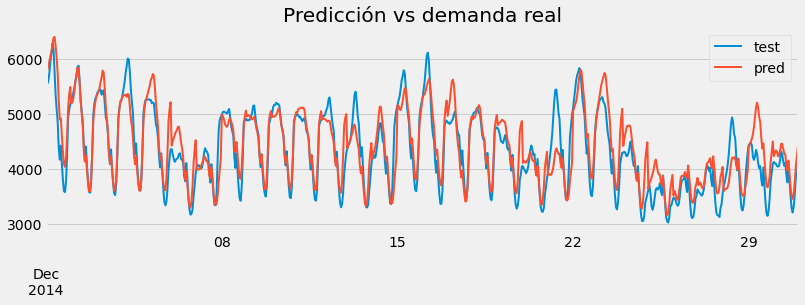

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                        )


fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: [251.93996462]


In [ ]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos.Demand,
                            initial_train_size  = len(datos.Demand[:fin_validacion]),
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(5)

Métrica backtesting: [251.93996462]


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.876561,5624.081576,5854.991298
2014-12-01 01:00:00,5802.876139,5647.464498,6018.255125
2014-12-01 02:00:00,5880.047528,5674.770104,6124.660370
2014-12-01 03:00:00,5953.541637,5711.169171,6267.055762
2014-12-01 04:00:00,6048.740321,5781.089902,6402.330366


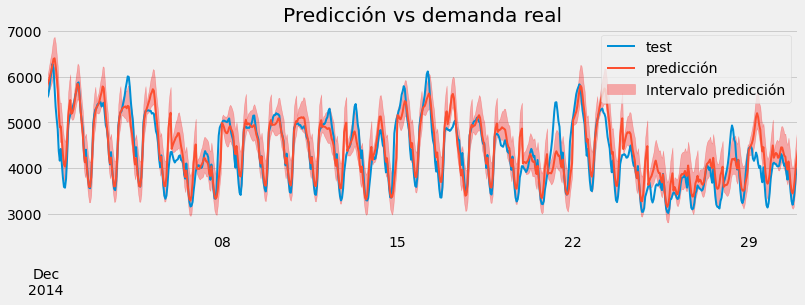

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción' 
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                     (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 72.08333333333333
